# Connect to drive & import libraries

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
%tensorflow_version 2.x

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import os
from keras.engine import Layer
import matplotlib.pyplot as plt
import keras
import numpy as np
import nltk
import tqdm
import tensorflow_hub as hub
import string
from keras import backend as K

Using TensorFlow backend.


In [4]:
tf.__version__

'2.2.0-rc3'

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=1a7b7fba82faa94b6749c1143117804f1d69b37154364e1f2cbfe11673cf81c9
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=868a94d5711313e74dc7d88c72a77c7503510f2e43680f593137bc2b5d135446
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=18882c9e56436659d016c3e31edde74b9cf8248bc92f53a4ed5444253019b909
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [0]:
import bert

# Constants

In [0]:
# data parameters
dataset_address = 'drive/My Drive/CA5_Sabri_810198312/Datasets/spam.csv'
test_data_percentage = 0.2
# model parameters
learning_rate = 0.0002
batch_size = 32
max_sequence_length = 128
number_of_epochs = [1, 10]
# model links
bert_model_hub_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
elmo_model_hub_link = 'https://tfhub.dev/google/elmo/3'

# Reading & Pre-processing the data

In [11]:
df = pd.read_csv(dataset_address, sep=',', encoding = "ISO-8859-1")
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [0]:
all_Y = df.v1.values
all_X = df.v2.values

## Create bert tokenizer

In [0]:
bert_layer = hub.KerasLayer(bert_model_hub_link)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer_instance = bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

### Bert functions for mask and id and segment id

In [0]:
def convert_text_to_number_and_fix_length(this_x, tokenizer_mod):
  this_x_ids = tokenizer_mod.convert_tokens_to_ids(this_x,)
  if len(this_x_ids) >= max_sequence_length:
    this_x_fix_len = this_x_ids[:max_sequence_length]
  else:
    this_x_fix_len = this_x_ids + [0]*(max_sequence_length - len(this_x_ids)) 
  return this_x_fix_len

def create_mask_for_input(this_x):
  if len(this_x) >= max_sequence_length:
    this_x_masks = [1]*max_sequence_length
  else:
    this_x_masks = [1]*len(this_x) + [0] * (max_sequence_length - len(this_x))
  return this_x_masks

def create_req_bert_inputs(all_X, tokenizer_mod):
  X_input_ids, X_input_masks, X_segment_ids = [], [], []

  for this_x in tqdm.tqdm(all_X, position=0, leave=True):
    X_input_ids.append(convert_text_to_number_and_fix_length(this_x, tokenizer_mod))
    X_input_masks.append(create_mask_for_input(this_x))
    X_segment_ids.append([0 for _ in range(max_sequence_length)])

  return X_input_ids, X_input_masks, X_segment_ids

## Clean and tokenize 

In [0]:
def clean_text(all_X, tokenizer_mod=None):
  nltk_eng_stopwords = nltk.corpus.stopwords.words('english')
  converted_X = []
  for this_x in all_X:
    this_x_tokenized = tokenizer_mod.tokenize(this_x)
    converted_X.append(this_x_tokenized)
  return converted_X

def convert_y_to_0_and_1(all_Y):
  label_number_mapping = {'ham': [1, 0], 'spam': [0, 1]}
  converted_y = [label_number_mapping[val] for val in all_Y]
  return converted_y

In [0]:
all_X_cleaned_using_bert = clean_text(all_X, bert_tokenizer_instance)

In [0]:
all_y_converted = convert_y_to_0_and_1(all_Y)

### Testing BERT results

In [18]:
print('X[0] => before: {} and after: {}'.format(all_X[0], all_X_cleaned_using_bert[0]))
print('Y[0] => before: {} and after: {}'.format(all_Y[0], all_y_converted[0]))

X[0] => before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... and after: ['go', 'until', 'ju', '##rong', 'point', ',', 'crazy', '.', '.', 'available', 'only', 'in', 'bug', '##is', 'n', 'great', 'world', 'la', 'e', 'buffet', '.', '.', '.', 'ci', '##ne', 'there', 'got', 'amore', 'wat', '.', '.', '.']
Y[0] => before: ham and after: [1, 0]


## Test Train split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(all_X_cleaned_using_bert, all_y_converted, test_size=test_data_percentage, random_state=42)

# Creating Model

## Using Bert

In [50]:
train_input_ids, train_input_masks, train_segment_ids = create_req_bert_inputs(X_train, bert_tokenizer_instance)
test_input_ids, test_input_masks, test_segment_ids = create_req_bert_inputs(X_test, bert_tokenizer_instance)

100%|██████████| 1115/1115 [00:00<00:00, 73140.07it/s]


In [51]:
type(train_input_masks)
np.asarray(train_input_masks, dtype=np.int32)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [52]:
bert_model_preped_input = [np.asarray(train_input_ids, dtype=np.int32), np.asarray(train_input_masks, dtype=np.int32), np.asarray(train_segment_ids, dtype=np.int32)]
len(bert_model_preped_input), bert_model_preped_input[0].shape, bert_model_preped_input[0][1].shape

(3, (4457, 128), (128,))

In [53]:
y_train = np.asarray(y_train)
type(bert_model_preped_input), type(bert_model_preped_input[0]), type(y_train), bert_model_preped_input[0][0]

(list,
 numpy.ndarray,
 numpy.ndarray,
 array([ 2053,  1045,  1005,  1049,  1999,  1996,  2168,  4049,  1012,
         2145,  2182,  2012,  2026,  3566,  2015,  1012,  4638,  2033,
         2041,  2006, 10930,  1012,  1045,  1005,  1049,  2431,  6248,
         1012,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   

In [0]:
this_optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

In [0]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="segment_ids")
  bert_layer = hub.KerasLayer(bert_model_hub_link,trainable=True)
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  pooling_lay = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
  dense = tf.keras.layers.Dense(768, activation='relu')(pooling_lay)
  pred = tf.keras.layers.Dense(2, activation='softmax')(dense)
  model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
  return model 

In [0]:
def plot_accuracy_and_loss(file_save_name, history):
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_accuracy.png')
  plt.cla()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_loss.png')
  plt.cla()

In [0]:
def evaluate_model(model):
  bert_model_test_input = [np.asarray(test_input_ids, dtype=np.int32), np.asarray(test_input_masks, dtype=np.int32), np.asarray(test_segment_ids, dtype=np.int32)]
  predicted_y = model.predict(bert_model_test_input)
  number_label_mapping = {0: 'ham', 1:'spam'}
  y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test]
  predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
  print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
  print('Classification report:', classification_report(y_test_conv, predicted_y_conv))
  print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
  print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
  print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
  y_test_for_auc = [np.argmax(val) for val in y_test]
  y_predicted_for_auc = [np.argmax(val) for val in predicted_y]
  fpr, tpr, thresholds = metrics.roc_curve(y_test_for_auc, y_predicted_for_auc, pos_label=1)
  print('AUC:', metrics.auc(fpr, tpr))

**1 Epoch**


```
Accuracy: 0.8654708520179372
Classification report:               precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

F1 (Micro): 0.8654708520179372
F1 (Macro): 0.46394230769230765
F1 (Weighted): 0.803057088651259
Recall (Micro): 0.8654708520179372
Recall (Macro): 0.5
Recall (Weighted): 0.8654708520179372
Precision (Micro): 0.8654708520179372
Precision (Macro): 0.4327354260089686
Precision (Weighted): 0.7490397956926541
AUC: 0.5
```

**10 Epochs**

```
Accuracy: 0.8654708520179372
Classification report:               precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

F1 (Micro): 0.8654708520179372
F1 (Macro): 0.46394230769230765
F1 (Weighted): 0.803057088651259
Recall (Micro): 0.8654708520179372
Recall (Macro): 0.5
Recall (Weighted): 0.8654708520179372
Precision (Micro): 0.8654708520179372
Precision (Macro): 0.4327354260089686
Precision (Weighted): 0.7490397956926541
AUC: 0.5
```

In [40]:
val_counts_in_train_y = {}
for val in y_train:
  if not str(val) in val_counts_in_train_y:
    val_counts_in_train_y[str(val)] = 0
  val_counts_in_train_y[str(val)] += 1
val_counts_in_train_y

{'[0 1]': 597, '[1 0]': 3860}

Number of epochs: 1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_m

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

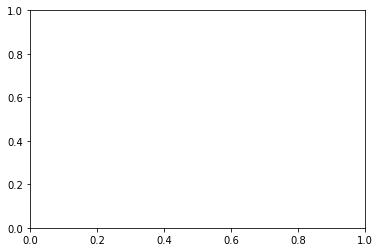

In [55]:
for epochs in number_of_epochs:
  print('Number of epochs:', epochs)
  model = create_model()
  print(model.summary())
  model.compile(loss='binary_crossentropy', optimizer=this_optimizer, metrics=['accuracy'])
  history = model.fit(
      bert_model_preped_input, 
      y_train,
      epochs=epochs,
      batch_size=batch_size
  )
  print('Done training')
  image_save_file_name = 'drive/My Drive/CA5_Sabri_810198312/Results/Q1_bert_model‌_no_preprocess_{}_epochs'.format(epochs)
  plot_accuracy_and_loss(image_save_file_name, history)
  evaluate_model(model)